<a href="https://colab.research.google.com/github/joaoleal02/ambev/blob/main/Sistema_iHops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import datetime
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style
import decimal

In [27]:
#importando a base de dados dos pdvs
data_ambev = pd.read_excel('rascunho.xlsx', index_col=None)
data_ambev.to_csv('rascunho.csv', encoding='utf-8', index=False)
data_ambev['Doc. Date'] = pd.to_datetime(data_ambev['Doc. Date'], format='%d/%m/%Y')
#postal como identificador do pdv
postalcode = 83630
#83630 é um exemplo de um pdv
dados = data_ambev.loc[data_ambev['Postal Code'] == postalcode]

In [28]:
beer_user = dados.iloc[0]['Subrand']
quantidade_comprada = (dados.iloc[0]['HL delivered'])*100
taxa_recomendacao = 0.1
quantidade_recomendada = quantidade_comprada * taxa_recomendacao 

In [29]:
#importando base de dados com as variaveis da cerveja
df = pd.read_csv("MLiHops.csv")

In [30]:
lista_cervas = []

#dicionario com as informacoes de cada cerveja de acordo com seu tipo
dicRecomendacao = {

  "Harmonizacao": {
  44 : "AMERICAN PALE ALE - Carnes grelhadas e saladas cítricas",
  2: "PALE LAGER - Hamburger, carnes vermelha e petiscos",
  43: "BROWN ALE - Carnes e petiscos",
  40: "WITBIER - Saladas, frutas do mar e comidas leves",
  42: "TRIPEL - Massas e frutos do mar",
  41: "BLONDE - Petiscos e frutos do mar",
  46: "STRONG - Frutos do mar e massas",
  45: "INDIAN PALE ALE - Queijo, carne vermelha, hamburger e petiscos",
  20: "FRUIT BEER - Sobremesa",
  },
  "Temperatura": {
  44: [8, 12],
  2: [0, 4],
  43: [8, 12],
  40: [4, 7],
  42: [4, 7],
  41: [2, 5],
  46: [10, 12],
  45: [8, 12],
  20: [7, 10],
  }
}

for i in range(len(df)):  #itera sobre as variaveis e adiciona na lista_cervas

    temp = []
    temp.clear()

    p1 = df.iloc[i]['ibu']
    temp.append(p1)
    p2 = df.iloc[i]['abv (%)']
    temp.append(p2)
    p3 = df.iloc[i]['corpo']
    temp.append(p3)
    p4 = df.iloc[i]['aroma']
    temp.append(p4)
    p5 = df.iloc[i]['tipo']
    temp.append(p5)

    lista_cervas.append(temp)
    
X = np.array(lista_cervas) #transforma a lista_cervas em numpy
mesma_escala = MinMaxScaler() #transforma os valores na mesma escala, para ter os mesmo peso
mesma_escala.fit(X)
data_transformed = mesma_escala.transform(X)

For n_clusters = 3 The average silhouette_score is : 0.26642470401035145
For n_clusters = 4 The average silhouette_score is : 0.293743712636453
For n_clusters = 5 The average silhouette_score is : 0.31348570018263117
For n_clusters = 6 The average silhouette_score is : 0.29355226266240797


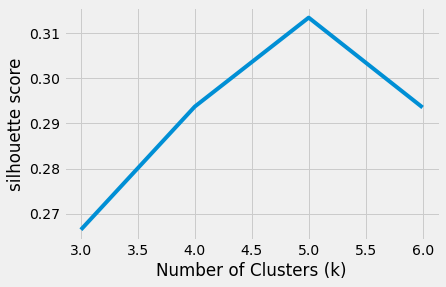

In [31]:
silhouette_avg_n_clusters = []

def range_clusters(n): #essa funcao acha o range que a gente precisa para tentar achar o numero de clusters
  lista = []
  a = 0
  c = 0
  while c < len(n)//2:
    a = c
    c += 1
    if a > 2:
      lista.append(a)
  return lista

lista = range_clusters(lista_cervas)
posicao_maior = 0
maior = 0
for n_clusters in lista: #esse for loop acha o numero de clusters para nosso KMeans

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(data_transformed)
    silhouette_avg = silhouette_score(data_transformed, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > maior:
      posicao_maior = n_clusters
      maior = silhouette_avg
    silhouette_avg_n_clusters.append(silhouette_avg)
    sample_silhouette_values = silhouette_samples(data_transformed, cluster_labels)

plt.show()

style.use("fivethirtyeight")
plt.plot(lista, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()
#O maior silhouette score mostra o numero de clusters ideal, e o grafico abaixo
#ilustra isso de uma forma mais organisada, onde 5 é o pico do grafico linha

In [32]:
#bota cada cerveja e suas variaveis em clusters das mais similares
kmeans = KMeans(n_clusters=posicao_maior, random_state=0).fit(X)
tips = kmeans.labels_

In [33]:
#busca uma cerveja e retorna a posicao dela no array
def busca(array,beer):
    for i,el in enumerate(array):
        if el==beer:
            return i
    return None

def arrendondar(x):
    return int(decimal.Decimal(x).quantize(0, decimal.ROUND_HALF_UP))

#recebe uma lista, soma os elementos e divide pela len (achar a media)
#Retorna None em caso de uma lista vazia (divisor 0)
def media_array(array):
  if len(array)==0:
    return None
  soma = 0
  for i in array:
    soma += i
  return(soma/len(array))

#Mostra o indice da ultima vez que uma cerveja foi comprada
def ultimaOcorrencia(df, cerveja):
  array = df["Subrand"].to_numpy()
  cont = 0
  while cont < len(array):
    if array[cont] == cerveja:
      return cont

    cont +=1
  return None

#calcula o preco medio a partir do tipo do container
def precoMedio_container(cerveja,conteiner,data_ambev,contador,quantidade_recomendada):

  quantidade_container = 0
  #filtra o dataframe
  data_ambev.sort_values(by=['Doc. Date'], inplace = True, ascending = False)
  df = data_ambev.loc[data_ambev['Unidade do container']==conteiner]
  df = df.loc[df["Subrand"] == cerveja]
  litros = df.iloc[0]['Litragem do container']
  ult = ultimaOcorrencia(df, cerveja)
  ult_data = df.iloc[ult]["Doc. Date"]
  #pega a faixa de tempo de 30 dias a partir da ultima ocorrencia
  dianovo = ult_data.day
  mesnovo = ult_data.month
  anonovo = ult_data.year
  primeirodia = dianovo
  primeiromes = mesnovo - 1
  primeiroano = anonovo
  if primeiromes == 0:
    primeiromes = 12
    primeiroano = anonovo - 1
  df = df.loc[(df['Doc. Date'] >= f'{primeirodia}/{primeiromes}/{primeiroano}') & (df['Doc. Date'] <= f'{dianovo}/{mesnovo}/{anonovo}')]
  data_array = df['Preco/L'].to_numpy()
  media = media_array(data_array)
  if media != None:
      if contador == 0:
          print("Recomendamos que voce compre %.2f litros dessa cerveja:"%(quantidade_recomendada))
      
      quantidade_container = arrendondar(quantidade_recomendada/litros)
      print("Opção %d: \n%d container(s) de %.2f L com %d unidade(s) cada,\ncom preco media do litro de $%.2f\nDando um total de $%.2f"
            %((contador+1),quantidade_container,litros,conteiner, media, quantidade_container * litros * media))
  return

#Inicializa a funcao do precoMedio, que calcula o preco medio por litro
def precoMedio(cerveja,quantidade_recomendada, data_ambev):

    filtered_df = data_ambev.loc[data_ambev["Subrand"] == cerveja].copy()
    array_available_conteiners = filtered_df['Unidade do container'].unique()
    num_conteiner = filtered_df['Unidade do container'].nunique()
    c = 0
    while c<num_conteiner:
        precoMedio_container(cerveja,array_available_conteiners[c], data_ambev,c,quantidade_recomendada)
        c+=1

    return


In [34]:
#converte coluna em numpy array
beer_array = df['subrand'].to_numpy()
tipo_array = df["tipo"].to_numpy()
#conversao do KMeans em cerveja
beer_index = busca(beer_array, beer_user)
beer_variaveis = lista_cervas[beer_index]
prediction = kmeans.predict([beer_variaveis])
prediction_index = np.where(tips == prediction)
#Iniciliazação das variaveis
beer_recommended = ""
cerveja_escolhida = []
print_out = ""
saida = False
#loop para as cervejas recomendadas
print("------------------------------------------------------------------")
for i in (prediction_index):
  for n in range(0, 1):
    new_array = np.delete(beer_array[i], np.where(beer_array[i] == beer_user))
    if len(new_array) >= 1:
      beer_recommended = random.choice(new_array)
      if beer_recommended != beer_user:
        saida = True
        cerveja_escolhida.append(beer_recommended)
        tipo_index = i[n]
        tipo_real = tipo_array[tipo_index]
        print("A cerveja recomendada é: ", beer_recommended)
        print_out = dicRecomendacao["Harmonizacao"][tipo_real]
        print(print_out)
        print_out = dicRecomendacao["Temperatura"][tipo_real]
        print("A temperatura ideal é entre: %d°C e %d°C\n" %(print_out[0],print_out[1]))
        precoMedio(beer_recommended,quantidade_recomendada, data_ambev)
        print("------------------------------------------------------------------")
    
#caso nao tenha cerveja recomendada
if saida == False:
  print("Nao temos recomendacao")
  print("------------------------------------------------------------------")

------------------------------------------------------------------
A cerveja recomendada é:  LEFFE LA LEGERE
PALE LAGER - Hamburger, carnes vermelha e petiscos
A temperatura ideal é entre: 0°C e 4°C

Recomendamos que voce compre 42.00 litros dessa cerveja:
Opção 1: 
7 container(s) de 6.00 L com 1 unidade(s) cada,
com preco media do litro de $2.71
Dando um total de $113.81
------------------------------------------------------------------
